In [5]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch
from utils.detect import FaceDetector
from model.mtcnn_pytorch import PNet, RNet,ONet
import matplotlib.pyplot as plt
import time
from functools import wraps


In [14]:
def show_boxes(img, boxes):
    
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)  
    for box in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

import matplotlib.pyplot as plt

def create_donut_chart(times, heading=None, labels=None, sizes=None, colors=None, explode=None, ax=None):
    if labels is None:
        labels = list(times.keys())
    if sizes is None:
        sizes = list(times.values())
    if colors is None:
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(labels)]
    if explode is None:
        explode = [0.1] + [0] * (len(labels) - 1)

    if ax is None:
        fig, ax = plt.subplots()

    ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
    
    # Draw circle
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Print another value in the middle
    total_time = sum(times.values())
    ax.text(0, 0, f'{total_time:.4f}s', horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')

    # Add heading
    if heading:
        ax.set_title(heading)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.tight_layout()

    if ax is None:
        plt.show()


def get_avg_values(profDict,itersize):
    out = {}
    for key,value in profDict.items():
        if len(value)>itersize:
            avg_value = sum(value[5:])/(len(value[5:])/itersize)
        else:
            avg_value = sum(value[5:])/(len(value[5:]))
        
        out[key] = avg_value
    return out


In [21]:
pnet = PNet()
rnet = RNet()

pnet.load_state_dict(torch.load("output/trainedModels/pnet.pth"))
rnet.load_state_dict(torch.load("output/trainedModels/rnet.pth"))

onet = ONet()
onet.load_caffe_model(
    np.load("output/trainedModels/onet.npy",allow_pickle=True)[()])

# Convert each model to TorchScript and save it with the suffix "_sc"
torch.jit.save(torch.jit.script(pnet), "output/trainedModels/pnet_sc_v2.pth")
torch.jit.save(torch.jit.script(rnet), "output/trainedModels/rnet_sc_v2.pth")
torch.jit.save(torch.jit.script(onet), "output/trainedModels/onet_sc.pth")

/home/srxdhxr/mtcnn4edge/model/mtcnn_pytorch.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/home/srxdhxr/mtcnn4edge/model/mtcnn_pytorch.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


In [9]:
#Load Torch Script Models
pnet = torch.jit.load("output/trainedModels/pnet_sc_v2.pth")
rnet = torch.jit.load("output/trainedModels/rnet_sc_v2.pth")
onet = torch.jit.load("output/trainedModels/onet_sc.pth")


Detection on Three Stage MTCNN


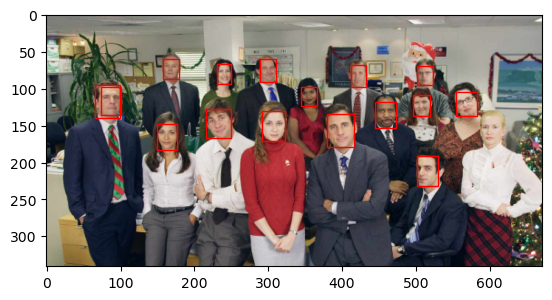

Detection on Two Stage MTCNN


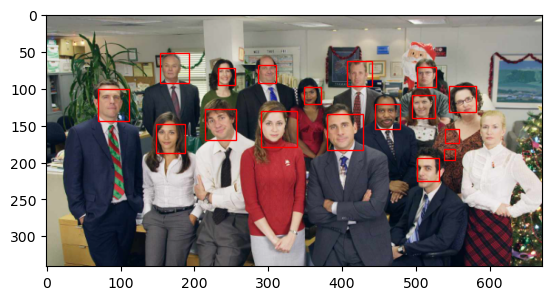

In [11]:
fd3stage = FaceDetector(pnet=pnet,rnet = rnet,onet = onet,device="cpu",use3stage = True,prof = True,use_jit = False)
fd2stage = FaceDetector(pnet=pnet,rnet = rnet,onet = onet,device="cpu",use3stage = False,prof = True, use_jit = False)

#Load Image
im_dir = "offic2.png"
img = Image.open(im_dir)
profs_2stage = []
profs_3stage = []
itersize = 10
for i in range(itersize):

    #Detect faces on three stage MTCNN P R and O Net
    boxes3stage = fd3stage.detect(im_dir)

    #Detect Faces on two stage MTCNN P R Net
    boxes2stage = fd2stage.detect(im_dir)


print("Detection on Three Stage MTCNN")
show_boxes(img,boxes3stage)
print("Detection on Two Stage MTCNN")
show_boxes(img,boxes2stage)


In [17]:
prof2stage = get_avg_values(fd2stage.get_prof(),itersize)
prof3stage = get_avg_values(fd3stage.get_prof(),itersize)

In [18]:
mtcnn2stage_time = prof2stage['stage_one']+prof2stage['stage_two']
mtecnn3stage_time = prof3stage['stage_one']+prof3stage['stage_two']+prof3stage['stage_three']

print(f"Total Detection Time in 2 Stage MTCNN: {mtcnn2stage_time:0.4f} seconds")
print(f"Total Detection Time in 3 Stage MTCNN: {mtecnn3stage_time:0.4f} seconds")

print(f"Overall Speed up: {(1-(mtcnn2stage_time/mtecnn3stage_time))*100:.4f}%" )

Total Detection Time in 2 Stage MTCNN: 0.0672 seconds
Total Detection Time in 3 Stage MTCNN: 0.1866 seconds
Overall Speed up: 63.9718%


## Performance Comparison of 3Stage MTCNN with 2Stage MTCNN Models

In [19]:
consolidated_2stage = {
    "inference_time": (prof2stage['stage_one']+prof2stage['stage_two']) - (prof2stage['nms_stage_one']+prof2stage['nms_stage_two']),
    "nms_time" : prof2stage['nms_stage_one']+prof2stage['nms_stage_two'],
    "preprocess_time": prof2stage['_preprocess']
}

consolidated_3stage = {
    "inference_time": (prof3stage['stage_one']+prof3stage['stage_two']+prof3stage['stage_three']) - (prof3stage['nms_stage_one']+prof3stage['nms_stage_two']+prof3stage['nms_stage_three']),
    "nms_time" : prof3stage['nms_stage_one']+prof3stage['nms_stage_two']+prof3stage['nms_stage_three'],
    "preprocess_time": prof3stage['_preprocess']
}

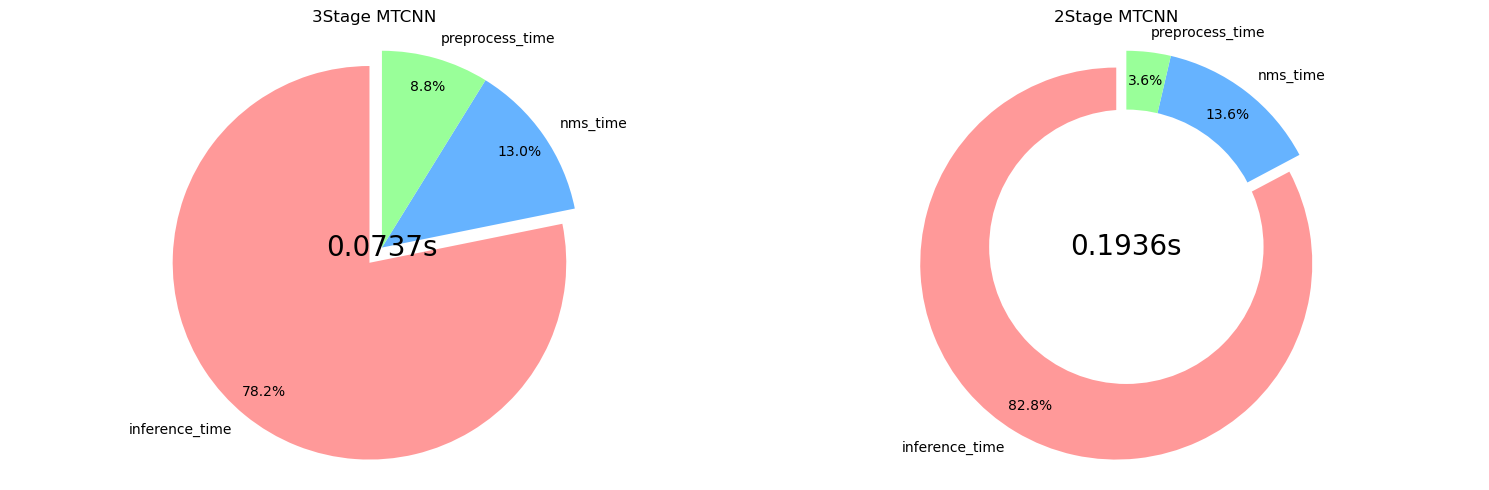

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(consolidated_2stage, heading="3Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(consolidated_3stage, heading="2Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])


From the above graphs, we observe that there is a reduction in model inference time and this results in a significant speedup. This is because the final ONet is completely ommited and the overall model inference time is reduced

# Model Quantization
Lets see if we can further reduce the model size and improve inference time by quantization. Since PNEt is already small, we will try to reduce the size of RNEt

In [26]:
import torch

def dynamic_quantize_torchscript_model(scripted_model):
    """
    Apply dynamic quantization to a TorchScript model and return the quantized model.
    
    Args:
        scripted_model (torch.jit.ScriptModule): The TorchScript model to be quantized.
    
    Returns:
        torch.jit.ScriptModule: The dynamically quantized TorchScript model.
    """
    # Apply dynamic quantization to the TorchScript model
    quantized_model = torch.quantization.quantize_dynamic(
        scripted_model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

def print_model_size_and_params(model):
    # Get the size of the model
    model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    model_size_mb = model_size_bytes / (1024 * 1024)  # Convert bytes to MB

    # Get the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Print the size and total parameters
    print(f"Model size: {model_size_mb:.2f} MB")
    print(f"Total parameters: {total_params}")

print("Before Quantization: ")
print_model_size_and_params(pnet)
print_model_size_and_params(rnet)





Before Quantization: 
Model size: 0.03 MB
Total parameters: 7670
Model size: 0.40 MB
Total parameters: 103558


As we see that RNET is almost 10 times larger than PNET, lets try to quantize the RNET Model

In [28]:
rnet_quantized = dynamic_quantize_torchscript_model(rnet)

In [29]:
print("After Quantization: ")
print_model_size_and_params(pnet)
print_model_size_and_params(rnet_quantized)


After Quantization: 
Model size: 0.03 MB
Total parameters: 7670
Model size: 0.11 MB
Total parameters: 28928


### Analysis of 2Stage MTCNN with JIT

Detection on Three Stage MTCNN with Torch Script models


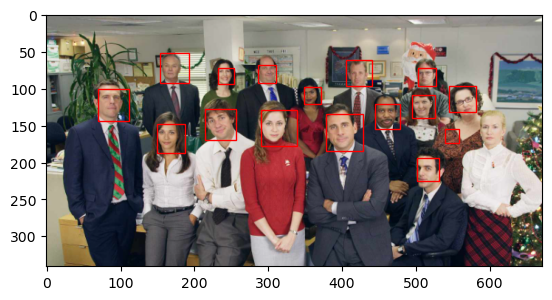

In [30]:
#Load Image
fd_jit = FaceDetector(pnet=pnet,rnet = rnet_quantized,onet = onet, device="cpu",prof=True,use3stage = False,use_jit=True)
img = Image.open(im_dir)
for i in range(itersize):
#Detect faces on two stage MTCNN P R by loading the torch script models
    boxes_sc = fd_jit.detect(im_dir)


print("Detection on Three Stage MTCNN with Torch Script models")
show_boxes(img,boxes_sc)

#Get average of times
prof2stage_jit = get_avg_values(fd_jit.get_prof(),itersize)

Total Detection Time in 2 Stage MTCNN: 0.0672 seconds
Total Detection Time in 3 Stage MTCNN: 0.0667 seconds
Overall Speed up: 0.8203%


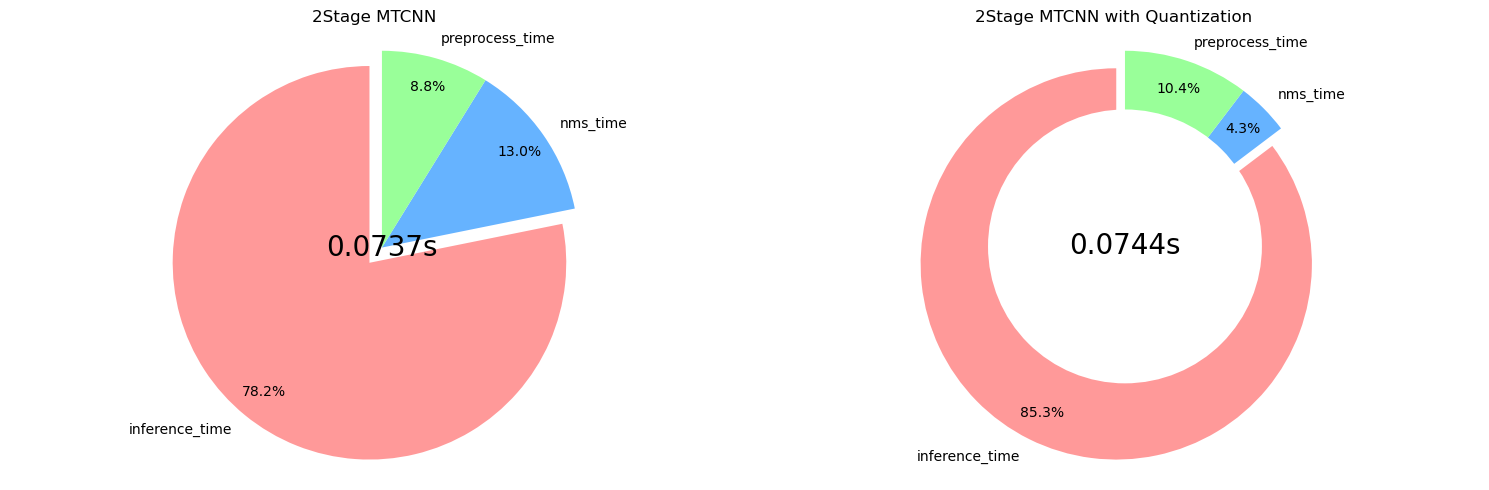

In [39]:
consolidated_2stage = {
    "inference_time": (prof2stage['stage_one']+prof2stage['stage_two']) - (prof2stage['nms_stage_one']+prof2stage['nms_stage_two']),
    "nms_time" : prof2stage['nms_stage_one']+prof2stage['nms_stage_two'],
    "preprocess_time": prof2stage['_preprocess']
}

consolidated_2stageq = {
    "inference_time": (prof2stage_jit['stage_one']+prof2stage_jit['stage_two']) - (prof2stage_jit['nms_stage_one']+prof2stage_jit['nms_stage_two']),
    "nms_time" : prof2stage_jit['nms_stage_one']+prof2stage_jit['nms_stage_two'],
    "preprocess_time": prof2stage_jit['_preprocess']
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(consolidated_2stage, heading="2Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(consolidated_2stageq, heading="2Stage MTCNN with Quantization ", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])

mtcnn2stage_time = prof2stage['stage_one']+prof2stage['stage_two']
mtecnn2stage_j = prof2stage_jit['stage_one']+prof2stage_jit['stage_two']

print(f"Total Detection Time in 2 Stage MTCNN: {mtcnn2stage_time:0.4f} seconds")
print(f"Total Detection Time in 3 Stage MTCNN: {mtecnn2stage_j:0.4f} seconds")

print(f"Overall Speed up: {((mtcnn2stage_time/mtecnn2stage_j)-1)*100:.4f}%" )

By Using JIT compilation on the Non Maximum Suppression Algorithm, a significan amount of time is reduced. NMS with JIT executes with more than double the speed! This significanly improves our speedup from 2Stage MTCNN without JIT Compilation

#### Lets see overall speedup from 3Stage MTCNN without JIT compilation to 2Stage MTCNN with JIT compilation

Total Detection Time in 2 Stage MTCNN: 0.1866 seconds
Total Detection Time in 3 Stage MTCNN: 0.0667 seconds
Overall Speed up: 179.8372%


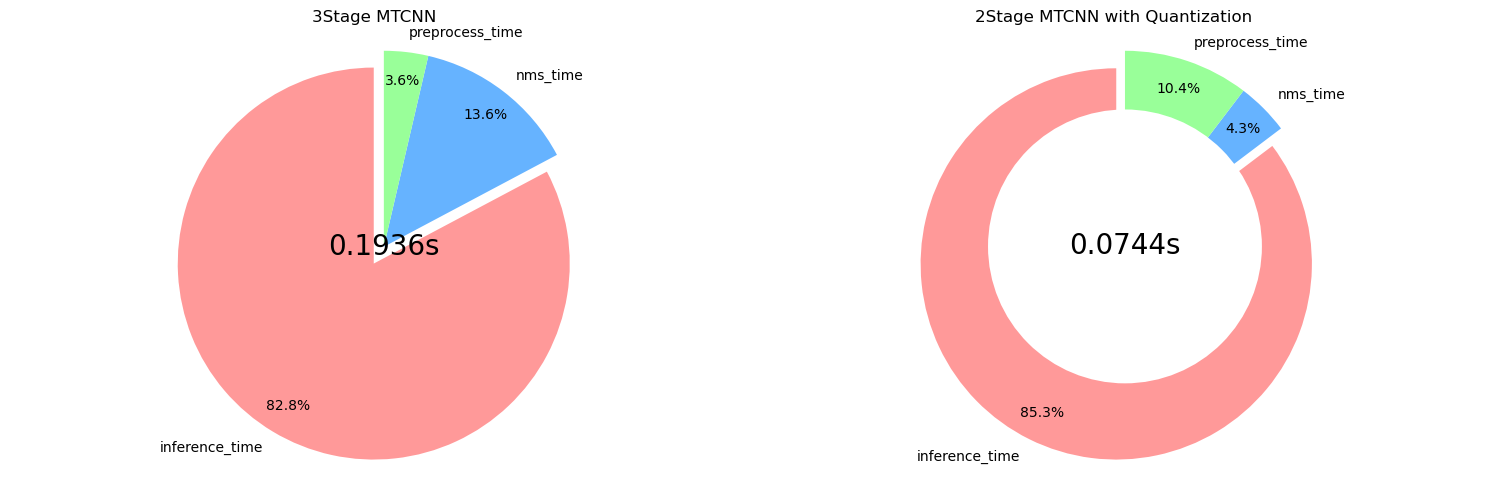

In [40]:
consolidated_2stage = {
    "inference_time": (prof2stage['stage_one']+prof2stage['stage_two']) - (prof2stage['nms_stage_one']+prof2stage['nms_stage_two']),
    "nms_time" : prof2stage['nms_stage_one']+prof2stage['nms_stage_two'],
    "preprocess_time": prof2stage['_preprocess']
}

consolidated_2stageq = {
    "inference_time": (prof2stage_jit['stage_one']+prof2stage_jit['stage_two']) - (prof2stage_jit['nms_stage_one']+prof2stage_jit['nms_stage_two']),
    "nms_time" : prof2stage_jit['nms_stage_one']+prof2stage_jit['nms_stage_two'],
    "preprocess_time": prof2stage_jit['_preprocess']
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
create_donut_chart(consolidated_3stage, heading="3Stage MTCNN", labels=None, sizes=None, colors=None, explode=None, ax=axes[0])
create_donut_chart(consolidated_2stageq, heading="2Stage MTCNN with Quantization ", labels=None, sizes=None, colors=None, explode=None, ax=axes[1])

mtcnn2stage_time = prof2stage['stage_one']+prof2stage['stage_two']
mtecnn2stage_j = prof2stage_jit['stage_one']+prof2stage_jit['stage_two']

print(f"Total Detection Time in 2 Stage MTCNN: {mtecnn3stage_time:0.4f} seconds")
print(f"Total Detection Time in 3 Stage MTCNN: {mtecnn2stage_j:0.4f} seconds")

print(f"Overall Speed up: {((mtecnn3stage_time/mtecnn2stage_j)-1)*100:.4f}%" )

# Conclusion
### Almost double speed up...Almost!
#### We were able to achieve almost double the speed from Reducing a stage in MTCNN and using JIT compilation. 